In [1]:
%matplotlib inline
%timeit

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import time
import pickle
import datetime
import re
import pyActigraphy

import sys
sys.path.append('/home/ngrav/project/')
from wearables.scripts import utils as wearutils
from wearables.scripts import data_v42 as weardata
from wearables.scripts import train as weartrain
from wearables.scripts import eval_v42 as weareval
from wearables.scripts import model as wearmodels
from wearables.scripts import DTW as weardtw

import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.spatial.distance import pdist, squareform
import fastdtw
import umap

plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=1
plt.rcParams['savefig.dpi'] = 600
sns.set_style("ticks")

In [5]:
# load data

model_fp = '/home/ngrav/scratch/wearables_model_zoo'

trainer_fp = os.path.join(model_fp, 'trainer_itrandaug_GA4.pkl')
modelpkl = os.path.join(model_fp, '752-itrandaug_GA4.pkl')

if not os.path.exists(trainer_fp) and os.path.exists(modelpkl):
    print('no pickles found along that path')

In [6]:

# best CNN
_, md_model, trainer = weardtw.data_from_trainer(trainer_fp, split='train')

# call eval to get output, modify for return_hidden = True option
evaluation = weareval.eval_trained(trainer, split='train',
                                   modelpkl=modelpkl,
                                   two_outputs=True)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/torch/nn/modules/conv.py:294: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/Convolution.cpp:660.)
  return F.conv1d(input, weight, bias, self.stride,
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


# fastdtw graph

1. D --> annoy --> clustering (unsupervised), then association with metadata
2. self-supervised embedding (~512dimensions) --> annoy based on D with various distance metrics OR DL based clustering, then association with metadata vs. GA association with metadata (otherwise, what is novel about the groups... do subclusters identify new interesting patients?)
3. 

In [229]:
# load previous
load = True

if load:
    # load it 
    with open('/home/ngrav/scratch/data_dtw.pkl', 'rb') as f:
        data_dtw = pickle.load(f)
        f.close()
else:
    # run it
    data_dtw = weardtw.rawdata_umap_dtw(trainer_fp) #

    # since this takes so long, save it
    with open('/home/ngrav/scratch/data_dtw.pkl', 'wb') as f:
        pickle.dump(data_dtw, f, protocol=pickle.HIGHEST_PROTOCOL)
        f.close()

In [230]:
# rerun umap, forgot to return data
data_dtw['data_umap'] = weardtw.embed(data_dtw['D'])

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


In [231]:
data_umap = data_dtw['data_umap']
md = data_dtw['md']

In [232]:
# add model output 
md = md.merge(pd.Series(evaluation.yhat.numpy(), name='actigraphy-GA', index=evaluation.id), left_index=True, right_index=True, how='left')
md['AbsErr'] = np.abs(md['GA'] - md['actigraphy-GA'])
md['actigraphyGA-GA'] = md['actigraphy-GA'] - md['GA']

In [39]:
pfp = '/home/ngrav/project/wearables/results/'

In [14]:
savefigs = True

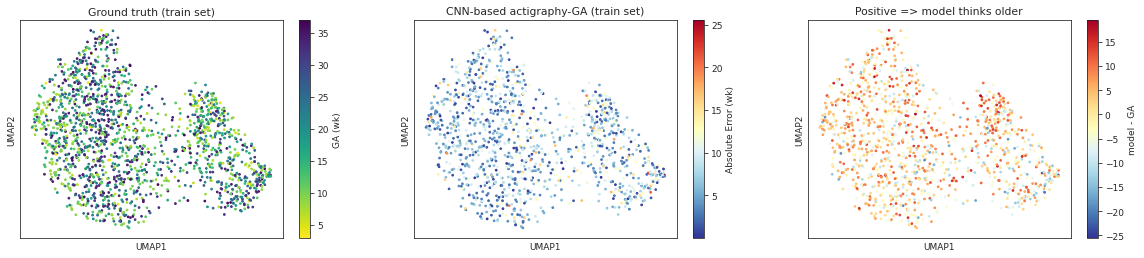

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
# ground truth
im = ax[0].scatter(data_umap[:, 0], data_umap[:, 1], 
                s=3,
                c=md['GA'], cmap='viridis_r')
fig.colorbar(im, label='GA (wk)', ax=ax[0])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('UMAP1')
ax[0].set_ylabel('UMAP2')
ax[0].set_title('Ground truth (train set)')

im = ax[1].scatter(data_umap[:, 0], data_umap[:, 1], 
                s=3,
                c=md['AbsErr'], cmap='RdYlBu_r')
fig.colorbar(im, label='Absolute Error (wk)', ax=ax[1])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('UMAP1')
ax[1].set_ylabel('UMAP2')
ax[1].set_title('CNN-based actigraphy-GA (train set)')

im = ax[2].scatter(data_umap[:, 0], data_umap[:, 1], 
                s=3,
                c=md['actigraphyGA-GA'], cmap='RdYlBu_r')
fig.colorbar(im, label='model - GA', ax=ax[2])
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel('UMAP1')
ax[2].set_ylabel('UMAP2')
ax[2].set_title('Positive => model thinks older')
if savefigs:
    fig.savefig(os.path.join(pfp, 'eval_umap_DTW.png'), bbox_inches='tight', dpi=600)

In [235]:
D = data_dtw['D']
membership = weardtw.leiden_clustering(D, gamma=0.5)
md['leiden'] = membership

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


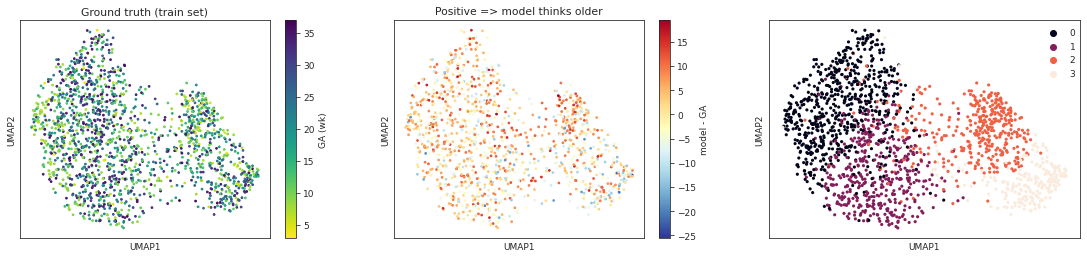

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(19, 4))
# ground truth
im = ax[0].scatter(data_umap[:, 0], data_umap[:, 1], 
                s=3,
                c=md['GA'], cmap='viridis_r')
fig.colorbar(im, label='GA (wk)', ax=ax[0])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('UMAP1')
ax[0].set_ylabel('UMAP2')
ax[0].set_title('Ground truth (train set)')

im = ax[1].scatter(data_umap[:, 0], data_umap[:, 1], 
                s=3,
                c=md['actigraphyGA-GA'], cmap='RdYlBu_r')
fig.colorbar(im, label='model - GA', ax=ax[1])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('UMAP1')
ax[1].set_ylabel('UMAP2')
ax[1].set_title('Positive => model thinks older')

sns.scatterplot(data_umap[:, 0], data_umap[:, 1], 
                s=10,
                hue=md['leiden'],
                palette='rocket',
                linewidth=0,
#                 palette='ocean', # tab20c
                legend='full', 
                ax=ax[2])
ax[2].legend(bbox_to_anchor=(1.01, 1))
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel('UMAP1')
ax[2].set_ylabel('UMAP2')
if savefigs:
    fig.savefig(os.path.join(pfp, 'eval_umap_DTW_leiden.png'), bbox_inches='tight', dpi=600)

### compare to model embeddings

Using suboptimal IT for now

In [25]:
md_model = md_model.loc[evaluation.id, :] # re-order to match output
md_model = md_model.merge(pd.Series(evaluation.yhat.numpy(), name='actigraphy-GA', index=evaluation.id), left_index=True, right_index=True, how='left')
md_model['AbsErr'] = np.abs(md_model['GA'] - md_model['actigraphy-GA'])
md_model['actigraphyGA-GA'] = md_model['actigraphy-GA'] - md_model['GA'] 

In [27]:
# need to optimize the metric selected (after pipeline for cluster annotation)

In [28]:
out2_umap = weardtw.embed(evaluation.out2, metric='manhattan')

In [33]:
from scipy.spatial.distance import pdist, squareform
D_model = squareform(pdist(evaluation.out2.numpy(), metric='cityblock'))
membership_model = weardtw.leiden_clustering(D_model, gamma=0.5)


In [34]:
# add clusters to md
md_model['leiden'] = membership_model

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


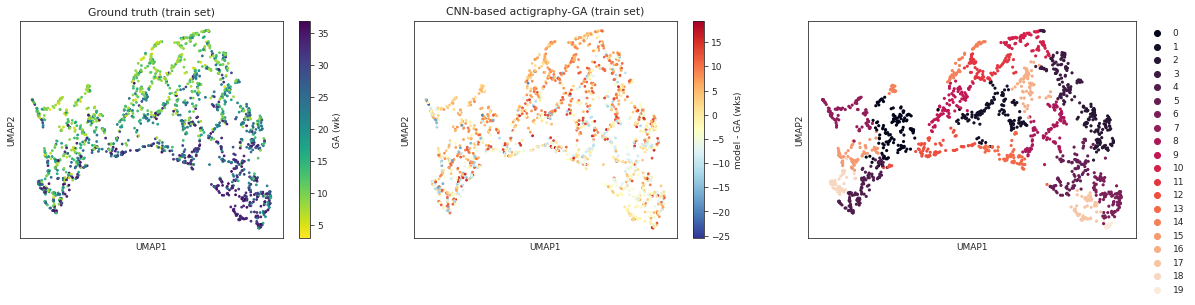

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
# ground truth
im = ax[0].scatter(out2_umap[:, 0], out2_umap[:, 1], 
                s=3,
                c=md_model['GA'], cmap='viridis_r')
fig.colorbar(im, label='GA (wk)', ax=ax[0])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('UMAP1')
ax[0].set_ylabel('UMAP2')
ax[0].set_title('Ground truth (train set)')

im = ax[1].scatter(out2_umap[:, 0], out2_umap[:, 1], 
                s=3,
                c=md_model['actigraphyGA-GA'], cmap='RdYlBu_r')
fig.colorbar(im, label='model - GA (wks)', ax=ax[1])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('UMAP1')
ax[1].set_ylabel('UMAP2')
ax[1].set_title('CNN-based actigraphy-GA (train set)')

sns.scatterplot(out2_umap[:, 0], out2_umap[:, 1], 
                s=10,
                hue=md_model['leiden'],
                palette='rocket',
                linewidth=0,
#                 palette='ocean', # tab20c
                legend='full', 
                ax=ax[2])
ax[2].legend(bbox_to_anchor=(1.01, 1))
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel('UMAP1')
ax[2].set_ylabel('UMAP2')
if savefigs:
    fig.savefig(os.path.join(pfp, 'eval_umap_itfeats_leiden.png'), bbox_inches='tight', dpi=600)

## random clustering

In [54]:
# load data

model_fp = '/home/ngrav/scratch/wearables_model_zoo'

bst_trainer = os.path.join(model_fp, 'trainer_cnnl1l2rand_GA3.pkl')
bst_modelpkl = os.path.join(model_fp, '388-cnnl1l2rand_GA3.pkl')

# best CNN
_, md_random, trainer = weardtw.data_from_trainer(bst_trainer)

# call eval to get output, modify for return_hidden = True option
evaluation = weareval.eval_trained(trainer, split='train',
                                   modelpkl=bst_modelpkl,
                                   two_outputs=True)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [55]:
# md_model = md.loc[evaluation.id, :]
randout2_umap = weardtw.embed(evaluation.out2, metric='manhattan')

In [56]:
# add model output 
md_random = md_random.loc[evaluation.id, :] # reorder
md_random = md_random.merge(pd.Series(evaluation.yhat.numpy(), name='actigraphy-GA', index=evaluation.id), left_index=True, right_index=True, how='left')
md_random['AbsErr'] = np.abs(md_random['GA'] - md_random['actigraphy-GA'])

In [57]:
pfp = '/home/ngrav/project/wearables/results/'

In [59]:
# cluster
from scipy.spatial.distance import pdist, squareform
D_random = squareform(pdist(evaluation.out2.numpy(), metric='cityblock'))
member_random = weardtw.leiden_clustering(D_random, gamma=0.5)
md_random['leiden'] = member_random

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


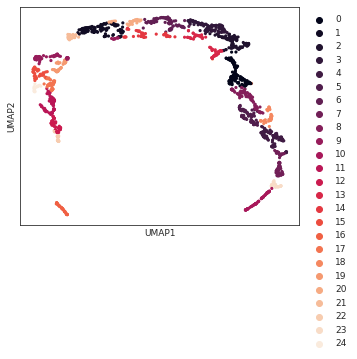

In [60]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
# ground truth
im = ax[0].scatter(randout2_umap[:, 0], randout2_umap[:, 1], 
                s=3,
                c=md_random['GA'], cmap='viridis_r')
fig.colorbar(im, label='GA (wk)', ax=ax[0])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('UMAP1')
ax[0].set_ylabel('UMAP2')
ax[0].set_title('Ground truth (train set)')

im = ax[1].scatter(randout2_umap[:, 0], randout2_umap[:, 1], 
                s=3,
                c=md_random['AbsErr'], cmap='RdYlBu_r')
fig.colorbar(im, label='Absolute Error (wk)', ax=ax[1])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('UMAP1')
ax[1].set_ylabel('UMAP2')
ax[1].set_title('CNN-based actigraphy-GA (train set)')

sns.scatterplot(randout2_umap[:, 0], randout2_umap[:, 1], 
                s=10,
                hue=md_random['leiden'],
                palette='rocket',
                linewidth=0,
#                 palette='ocean', # tab20c
                legend='full', 
                ax=ax[2])
ax[2].legend(bbox_to_anchor=(1.01, 1))
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel('UMAP1')
ax[2].set_ylabel('UMAP2')
if savefigs:
    fig.savefig(os.path.join(pfp, 'eval_umap_random.png'), bbox_inches='tight', dpi=600)

# cluster analysis

Place clusters in metadata df and analyze for differences

*data*: 
- `md`: from unsupervised DTW embedding
- `md_model`: from model embeddings
- `md_random`: from random model embeddings (label shuffling)

In [43]:
voi = trainer.data.data['voi']

In [44]:
from sklearn.metrics.cluster import contingency_matrix

In [246]:
def sigvars_per_cluster(metadata, voi, cluster_key='leiden', bonferonni_crct=True):
    def pval2sigvarlist(sigvars_per_cluster_results, p_cutoff=0.001):
        dt = sigvars_per_cluster_results.loc[((sigvars_per_cluster_results < p_cutoff).sum(1)==1), :] < p_cutoff
        cluster_sig_vars = {}
        for col in dt.columns:
            cluster_sig_vars[col] = dt.loc[dt[col], col].index.to_list()
        return cluster_sig_vars
    from scipy.stats import chi2_contingency
    from scipy.stats import kruskal
    results = {c:{} for c in np.sort(metadata[cluster_key].unique())}
    # one-vs-rest scheme
    for i, c in enumerate(np.sort(metadata[cluster_key].unique())):
        metadata['cluster_part'] = (metadata[cluster_key] == c)
        for ii, v in enumerate(voi.keys()):
            if voi[v][1] == 'continuous':
                v_c = metadata.loc[metadata[cluster_key]==c, v]
                v_notc = metadata.loc[metadata[cluster_key]!=c, v]
                statistic, p = kruskal(v_c, v_notc)
            else:
                obs = metadata.groupby([v, 'cluster_part']).size().unstack(fill_value=0)
                chi2, p, dof, expected = chi2_contingency(obs) # Fischer's?
            results[c][v] = p / len(voi.keys()) if bonferonni_crct else p
    return pval2sigvarlist(pd.DataFrame(results))

In [300]:
def sigvars_per_cluster(metadata, voi, cluster_key='leiden', bonferonni_crct=True, verbose=True):
    '''Exclusive significance in cluster that is enriched categorically or has log2FC average >=0.5.'''
    def pval2sigvarlist(res, p_cutoff=0.001 / len(voi.keys()) if bonferonni_crct else 0.001, min_l2fc=0.5):
        filtered_res = {k:[] for k in res.keys()}
        for cid in res.keys():
            other_cids = [i for i in res.keys() if i!=cid]
            for var, val in res[cid].items():
                if (val[0] <= p_cutoff and not any([True if res[k][var][0] <= p_cutoff else False for k in other_cids])) and (isinstance(val[1], np.float32) and np.abs(val[1]) >= min_l2fc):
                    filtered_res[cid].append({'name': '{}_l2fc(c-rest)={:.2f}'.format(var, val[1]),
                                              'P_adj': val[0] / len(voi.keys()) if bonferonni_crct else val[0], 'log2fc(c-rest)': val[1]})
                elif (val[0] <= p_cutoff and not any([True if res[k][var][0] <= p_cutoff else False for k in other_cids])) and (isinstance(val[1], pd.DataFrame) and np.unravel_index(np.argmax(val[1].abs()), val[1].shape)[1] == 1):
                    idx = np.unravel_index(np.argmax(val[1].abs()), val[1].shape)
                    filtered_res[cid].append({'name': '{}={} enriched by {:.2f}-%'.format(var, val[1].index[idx[0]], 100*val[1].iloc[idx]),
                                         'P_adj': val[0] / len(voi.keys()) if bonferonni_crct else val[0], 'obs/exp-1': val[1]})
        return filtered_res
    from scipy.stats import chi2_contingency
    from scipy.stats import kruskal
    results = {c:{} for c in np.sort(metadata[cluster_key].unique())}
    # one-vs-rest scheme
    for i, c in enumerate(np.sort(metadata[cluster_key].unique())):
        metadata['cluster_part'] = (metadata[cluster_key] == c)
        for ii, v in enumerate(voi.keys()):
            if voi[v][1] == 'continuous':
                v_c = metadata.loc[metadata[cluster_key]==c, v]
                v_notc = metadata.loc[metadata[cluster_key]!=c, v]
                statistic, p = kruskal(v_c, v_notc)
                metric = np.log2(np.nanmean(v_c)) - np.log2(np.nanmean(v_notc)) # log2FC
                metric = np.float32(metric)
            else:
                obs = metadata.groupby([v, 'cluster_part']).size().unstack(fill_value=0)
                chi2, p, dof, expected = chi2_contingency(obs) # Fischer's?
                metric = ((obs / expected) - 1) # obs/expected ratio
            results[c][v] = ( p, metric )
    out = pval2sigvarlist(results)
    if verbose:
        for k in np.sort(list(out.keys())):
            for v in out[k]:
                print('cluster_id: {}, annotation: {}'.format(k, v['name'])) 
    return out

In [303]:
dtw_clustanal = sigvars_per_cluster(md, voi)
# rand_clustanal = sigvars_per_cluster(md_random, voi)

/tmp/ipykernel_3229959/423491997.py:27: RuntimeWarning: invalid value encountered in log2
  metric = np.log2(np.nanmean(v_c)) - np.log2(np.nanmean(v_notc)) # log2FC


cluster_id: 0, annotation: work_hrs1=4.0 enriched by 33.24-%
cluster_id: 2, annotation: period_window1=1.0 enriched by 74.11-%
cluster_id: 2, annotation: menstrual_days1=0.0 enriched by 86.92-%
cluster_id: 2, annotation: premature_birth1=0.0 enriched by 70.96-%
cluster_id: 2, annotation: stress1_1=0.0 enriched by 109.24-%
cluster_id: 2, annotation: stress7_1=0.0 enriched by 109.24-%
cluster_id: 2, annotation: stress9_1=0.0 enriched by 106.16-%
cluster_id: 2, annotation: choosesleep_1trim=0.0 enriched by 128.98-%
cluster_id: 2, annotation: slpwake_1trim=0.0 enriched by 124.30-%
cluster_id: 2, annotation: slp30_1trim=0.0 enriched by 124.30-%
cluster_id: 2, annotation: sleep_qual1=0.0 enriched by 124.30-%
cluster_id: 2, annotation: slpenergy1=0.0 enriched by 124.30-%
cluster_id: 2, annotation: sitting1=0.0 enriched by 122.52-%
cluster_id: 2, annotation: tv1=0.0 enriched by 122.52-%
cluster_id: 2, annotation: inactive1=0.0 enriched by 122.52-%
cluster_id: 2, annotation: passenger1=0.0 enri

In [304]:
model_clustanal = sigvars_per_cluster(md_model, voi)

/tmp/ipykernel_3229959/423491997.py:27: RuntimeWarning: invalid value encountered in log2
  metric = np.log2(np.nanmean(v_c)) - np.log2(np.nanmean(v_notc)) # log2FC


cluster_id: 0, annotation: premature_birth1=0.0 enriched by 124.09-%
cluster_id: 4, annotation: race=0.0 enriched by -46.96-%
cluster_id: 6, annotation: work_hrs1=4.0 enriched by 114.01-%
cluster_id: 14, annotation: edinb10_1trim=4.0 enriched by 2364.29-%
cluster_id: 15, annotation: period_window1=0.0 enriched by 124.72-%
cluster_id: 15, annotation: workreg_1trim=0.0 enriched by 235.82-%
cluster_id: 15, annotation: slpwake_1trim=0.0 enriched by 201.42-%
cluster_id: 15, annotation: slpenergy1=0.0 enriched by 201.42-%
cluster_id: 15, annotation: inactive1=0.0 enriched by 197.20-%
cluster_id: 18, annotation: sleep_qual1=4.0 enriched by 196.90-%


In [281]:
res = dtw_clustanal

In [289]:
var = 'asthma_yes___3'
val = res[0][var]

In [295]:
other_cids = [1, 2, 3]

In [299]:
not any([True if res[k][var][0] <= p_cutoff else False for k in other_cids])

True

In [291]:
p_cutoff = 0.001 / len(voi.keys()) if True else 0.001 

In [293]:
val[0] <= p_cutoff

False

In [239]:
print('\nDTW: ')
for k in np.sort(list(dtw_clustanal.keys())):
    print('  {}:'.format(k), dtw_clustanal[k])
print('\nModel: ')
for k in np.sort(list(model_clustanal.keys())):
    print('  {}:'.format(k), model_clustanal[k])
print('\nRandom: ')
for k in np.sort(list(rand_clustanal.keys())):
    print('  {}:'.format(k), rand_clustanal[k])        



DTW: 
  0: ['asthma_yes___3']
  1: ['epidural', 'neonatal_complication']
  2: ['asthma_yes___1', 'ervisit', 'regular_period1', 'edinb9_1trim']
  3: ['asthma_yes___10', 'asthma_yes___13', 'edinb5_1trim', 'edinb10_1trim']

Model: 
  0: ['asthma_yes___3']
  1: []
  2: []
  3: ['neonatal_complication']
  4: ['abuse']
  5: []
  6: ['ven_pco2']
  7: []
  8: ['preeclampsia']
  9: []
  10: ['ven_ph', 'death_baby']
  11: ['asthma_yes___2']
  12: []
  13: ['asthma_yes___8', 'gestational_diabetes', 'cbc_plts']
  14: []
  15: ['edinb5_1trim']
  16: []
  17: ['assist_repro']
  18: []
  19: []

Random: 


NameError: name 'rand_clustanal' is not defined

In [70]:
# calc odds_ratio
md.groupby('leiden').count().head()

,record_id,age_enroll,marital,gestage_by,insur,ethnicity,race,bmi_1vis,prior_ptb_all,fullterm_births,...,edinb4_1trim,edinb5_1trim,edinb6_1trim,edinb7_1trim,edinb8_1trim,edinb9_1trim,edinb10_1trim,GA,actigraphy-GA,AbsErr
leiden,,,,,,,,,,,,,,,,,,,,,
0,697,697,697,697,697,697,697,697,697,697,...,697,697,697,697,697,697,697,697,697,697
1,413,413,413,413,413,413,413,413,413,413,...,413,413,413,413,413,413,413,413,413,413
2,310,310,310,310,310,310,310,310,310,310,...,310,310,310,310,310,310,310,310,310,310
3,248,248,248,248,248,248,248,248,248,248,...,248,248,248,248,248,248,248,248,248,248
4,61,61,61,61,61,61,61,61,61,61,...,61,61,61,61,61,61,61,61,61,61


## dev pairwise DTW

**Observations**
- even with `n_jobs=32`, the sklearn implementation is slower than the scipy pdist

In [10]:
def pdtw(mat):
    return pdist(mat, lambda u, v: fastdtw.fastdtw(u, v)[0])

In [8]:
x.shape

torch.Size([64, 2, 10080])

In [11]:
# take only activity
x = x[:, 0, :]
x.shape

torch.Size([64, 10080])

In [14]:
tic = time.time()
d_mb = pdtw(x)
print('{:.0f}s'.format(time.time() - tic))

9s


In [16]:
# compare with paralellized scikit learn pairwise_distances 
from sklearn.metrics.pairwise import pairwise_distances

In [24]:
tic = time.time()
d_mb_sklearn = pairwise_distances(x, metric=lambda u, v: fastdtw.fastdtw(u, v)[0], n_jobs=32)
print('{:.0f}s'.format(time.time() - tic))

22s


In [22]:
print(d_mb.shape)
print(d_mb_sklearn.shape)

(2016,)
(64, 64)




## tshoot slow eval

attempts:
- tried to change num_workers of the dataloader to 1, in case there was some problem with the leaking. This did not solve the problem of the thing getting stuck after batch 1 loading
- tried changing pin_memory=False for the dataloader. This got through one additional batch loading but stopped on the third (test needs to go through ~11 batches)
- combination of both solved issue. After trying ablation again, getting rid of `dataloader.num_workers = 1` causes a pause. Then changing `dataloader.pin_memory = False` but keeping `dataloader.num_woerkers = 1` makes the eval fast again. SO, the issue was indeed the num_workers